c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

Accuracy: 0.77
Recall: 0.90
Precision: 0.46
F1 Score: 0.61


C:\Users\miersja\AppData\Local\Temp\ipykernel_32524\2973946006.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['', 'Low Risk', 'Medium/High Risk'])
C:\Users\miersja\AppData\Local\Temp\ipykernel_32524\2973946006.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['', 'Low Risk', 'Medium/High Risk'])


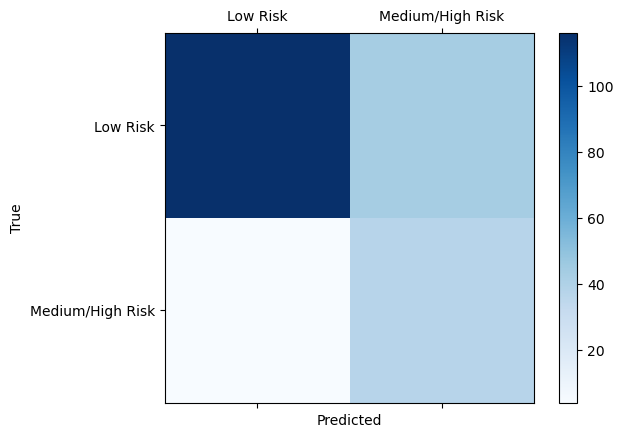

Records die hoogstwaarschijnlijk fraude zijn (High Risk):
     rijksregisterPatient  rijksregisterNurse  \
8             92617890983         32297728967   
15            45570959585         58995812846   
19            67567873330         98048345768   
25            51089684617         75774786532   
30            25954431108         45535696612   
31            47916800561         63636655411   
46            99281992745         68211687353   
52            88756073181         78311071207   
58            59819897341         35456694225   
68            75471565954         36635537691   
97            47204802135         88948808960   
105           90332470354         16380030584   
111           73714599303         43828980581   
112           51052904386         36142254216   
114           41516565581         93974980832   
116           50671789924         23121906065   
120           18870482675         80403339448   
121           82478357649         22298652716   
124        

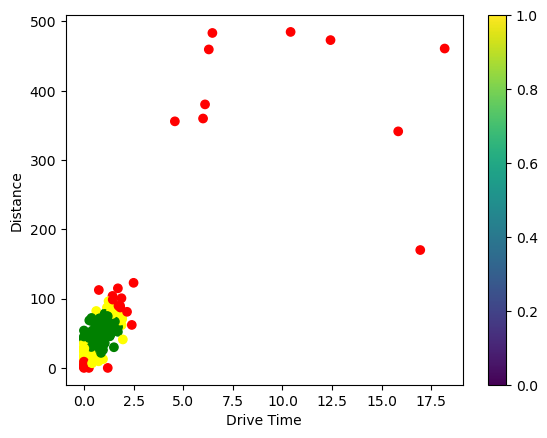

In [12]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Data laden
data = pd.read_json('./geo_data.json')

# Voorbereiding van de features
X = data[['driveTime', 'distance']].values

# Standaardisatie van de features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Definieer de parameter grid voor K-means
param_grid = {
    'n_clusters': range(2, 6),
    'n_init': [10, 20, 30, 40],
    'max_iter': [300, 400, 500]
}

# K-means model
kmeans = KMeans(random_state=42)

# Gebruik GridSearchCV voor hyperparameter optimalisatie
grid_search = GridSearchCV(kmeans, param_grid, cv=5, scoring='f1')
grid_search.fit(X_scaled)

# Beste model kiezen
best_kmeans = grid_search.best_estimator_
clusters = best_kmeans.predict(X_scaled)

# Afstanden van elk punt tot het clustercentrum berekenen
distances = best_kmeans.transform(X_scaled).min(axis=1)
distance_threshold_high = np.percentile(distances, 85)
distance_threshold_medium = np.percentile(distances, 60)

# Risiconiveaus toewijzen op basis van afstand en reistijd
data['Fraud Risk'] = np.where(distances >= distance_threshold_high, 'High Risk',
                             np.where(distances >= distance_threshold_medium, 'Medium Risk', 'Low Risk'))

# Simulatie van 'true labels' voor demonstratiedoeleinden
thresholds = data[['driveTime', 'distance']].quantile(0.85)
true_labels = ((data['driveTime'] > thresholds['driveTime']) | 
               (data['distance'] > thresholds['distance'])).astype(int)
predicted_labels = data['Fraud Risk'].apply(lambda x: 1 if x != 'Low Risk' else 0)

# Prestatiemetingen
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f'Accuracy: {accuracy:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1:.2f}')

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_xticklabels(['', 'Low Risk', 'Medium/High Risk'])
ax.set_yticklabels(['', 'Low Risk', 'Medium/High Risk'])
plt.show()

# Filter en toon records die geclassificeerd zijn als 'High Risk' en 'Medium Risk'
high_risk_records = data[data['Fraud Risk'] == 'High Risk']
medium_risk_records = data[data['Fraud Risk'] == 'Medium Risk']
low_risk_records = data[data['Fraud Risk'] == 'Low Risk']

print("Records die hoogstwaarschijnlijk fraude zijn (High Risk):")
print(high_risk_records)
print("Records die mogelijk fraude zijn (Medium Risk):")
print(medium_risk_records)

# Tel het aantal records in elke risicocategorie
high_risk_count = high_risk_records.shape[0]
medium_risk_count = medium_risk_records.shape[0]
low_risk_count = low_risk_records.shape[0]

print(f"Aantal 'High Risk' records: {high_risk_count}")
print(f"Aantal 'Medium Risk' records: {medium_risk_count}")
print(f"Aantal 'Low Risk' records: {low_risk_count}")

# Exporteer de 'High Risk' en 'Medium Risk' records naar een JSON-object
high_risk_records_json = high_risk_records.to_json(orient='records', lines=True)
medium_risk_records_json = medium_risk_records.to_json(orient='records', lines=True)
print("JSON Output van hoogstwaarschijnlijke fraude records (High Risk):")
print(high_risk_records_json)
print("JSON Output van mogelijk frauduleuze records (Medium Risk):")
print(medium_risk_records_json)

# Visualisatie van de clusters
plt.scatter(data['driveTime'], data['distance'], c=data['Fraud Risk'].map({'Low Risk': 'green', 'Medium Risk': 'yellow', 'High Risk': 'red'}))
plt.xlabel('Drive Time')
plt.ylabel('Distance')
plt.colorbar()
plt.show()
